### Librerías

In [1]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns

### Lectura y preprocesamiento de datos

In [2]:
df = pd.read_csv('mission_launches.csv').drop(columns=['Unnamed: 0.1','Unnamed: 0'])

df.rename(columns={'Company Name':'company',
                   'Location':'launch_facility',
                   'Datum':'date',
                   'Detail':'detail',
                   'Status Rocket':'rocket_status',
                   ' Rocket':'cost',
                   'Status Mission':'mission_status'},
          inplace=True)


#Cantidad de valores nulos y filas repetidas

# print(f'Hay un total de {df.isna().sum().sum()} valores nulos distribuidos así:',
#       f'\nCost: {df["cost"].isna().sum()} ({df["cost"].isna().sum()/df.shape[0]*100:.2f}% del total)')

##Conversión de la columna de fechas. Algunos valores de la columna tiene fecha y hora pero otros solo tienen fecha.
df['date'] = df['date'].str.replace(' UTC','')

def conversor_fechas(fechas):
    if ':' in fechas:
        return pd.to_datetime(fechas, format= '%a %b %d, %Y %H:%M')
    else:
        return pd.to_datetime(fechas, format= '%a %b %d, %Y')
        
df['date'] = df['date'].apply(conversor_fechas)

df['cost'] = df['cost'].str.replace(',','')
df['cost'] = df['cost'].astype(float)

##Creación de medidas derivadas

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

##Obtener el país de lanzamiento del cohete
df['launch_location'] = df['launch_facility'].str.split(', ').str[-1]

##La columna detail tiene el nombre del cohete y la carga que lleva, hay que dividirla

df[['rocket','load']] = df['detail'].str.split('|',expand=True)
df.drop(columns='detail',inplace=True)

##Es necesario reasignar algunos lugares de lanzamiento que no dicen directamente el nombre del país.
df['launch_location'].value_counts();

dict_changes = {
    'New Mexico' : 'USA',
    "Yellow Sea": 'China',
    "Shahrud Missile Test Site": "Iran",
    "Pacific Missile Range Facility": 'USA',
    "Barents Sea": 'Russia',
    "Gran Canaria": 'USA'
}
df['launch_location'] = df['launch_location'].replace(dict_changes)

##Organizar los datos por fecha

df = df.sort_values('date').reset_index(drop=True)

## Estilos estéticos

In [3]:
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

### Análisis exploratorio de datos

In [4]:
df['rocket_status'].value_counts().index

Index(['StatusRetired', 'StatusActive'], dtype='object', name='rocket_status')

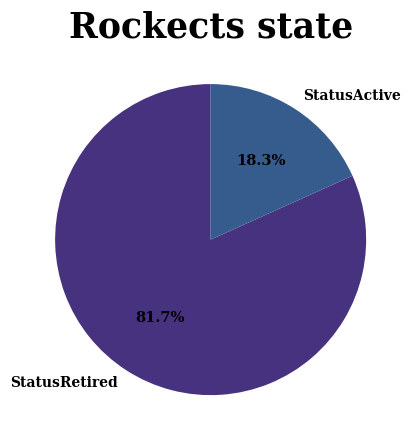

In [21]:
##Cohetes activos vs retirados
plt.title('Rockects state')
plt.pie(df['rocket_status'].value_counts(),startangle=90,
        labels=df['rocket_status'].value_counts().index,autopct='%.1f%%',
        colors=sns.color_palette(palette='viridis'))
plt.show()

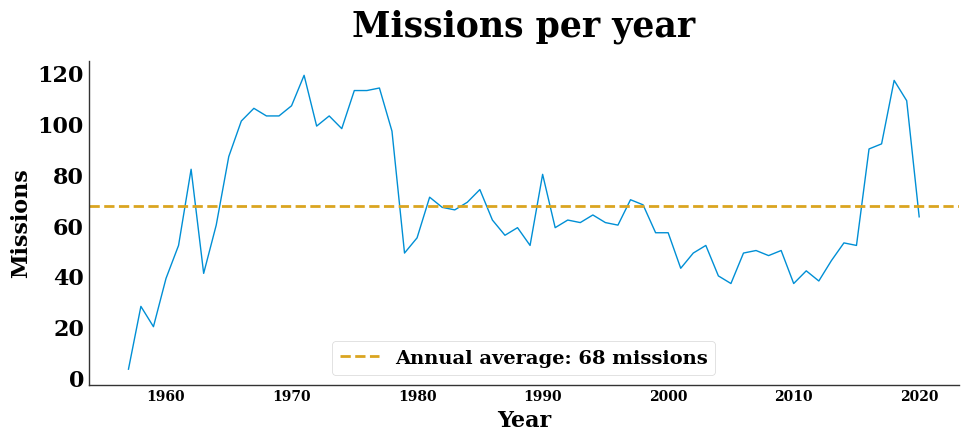

In [36]:
##Cambio de la cantidad de misiones
misiones_por_year = df.groupby('year')['company'].count().reset_index()

fig, ax = plt.subplots(figsize=(10,4))

misiones_por_year.plot(lw=1,x='year',ax=ax).set_title('Missions per year',y=1.05)

##Promedio de lanzamientos por año

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Missions')
mean = ax.axhline(misiones_por_year['company'].mean(),lw=2, ls='--',color='goldenrod',label=f'Annual average: {misiones_por_year["company"].mean():.0f} missions')
ax.legend(handles=[mean],loc='lower center')
plt.show()

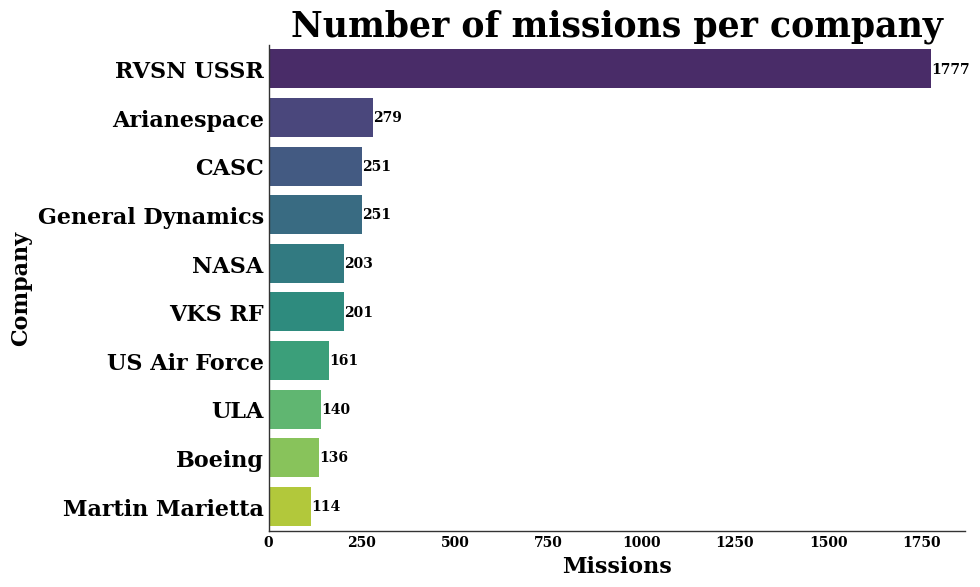

In [37]:
##Misiones por compañía

top_10_companies = df['company'].value_counts(sort=True).head(10).reset_index()

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(data=top_10_companies,y='company',x='count',hue='company',palette='viridis')

ax.set_title('Number of missions per company')
ax.set_ylabel('Company')
ax.set_xlabel('Missions')
ax.spines[['top','right']].set_visible(False)

##Etiquetas
for i, valor in enumerate(top_10_companies['count']):
    plt.text(valor + 0.5, i, str(valor), va='center', ha='left',fontsize=10)


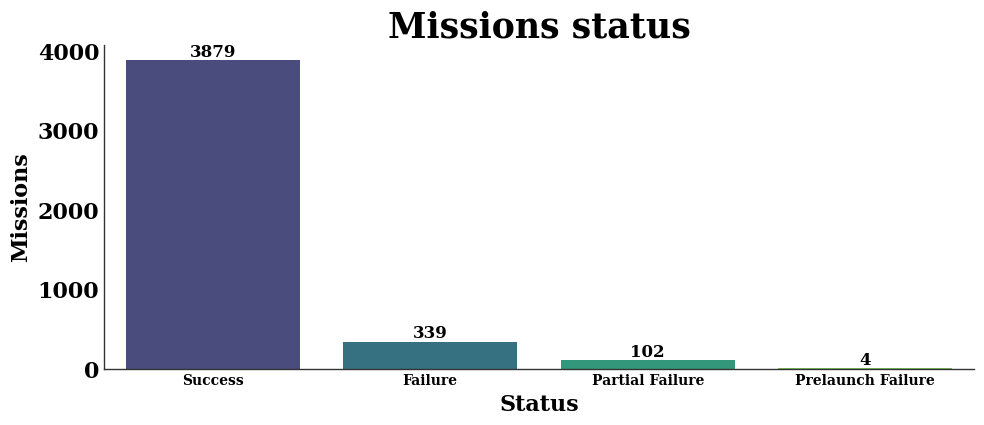

In [38]:
##Estado de las misiones

mission_status = df['mission_status'].value_counts(sort=True).reset_index()


##Figura
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(data=mission_status,x='mission_status',y='count',hue='mission_status',palette='viridis',ax=ax)

ax.set_title('Missions status')
ax.set_xlabel('Status')
ax.set_ylabel('Missions')
ax.spines[['top','right']].set_visible(False)

for i, valor in enumerate(mission_status['count']):
    plt.text(i, valor + 0.5, str(valor), ha='center', va='bottom', fontsize=12)

plt.show()




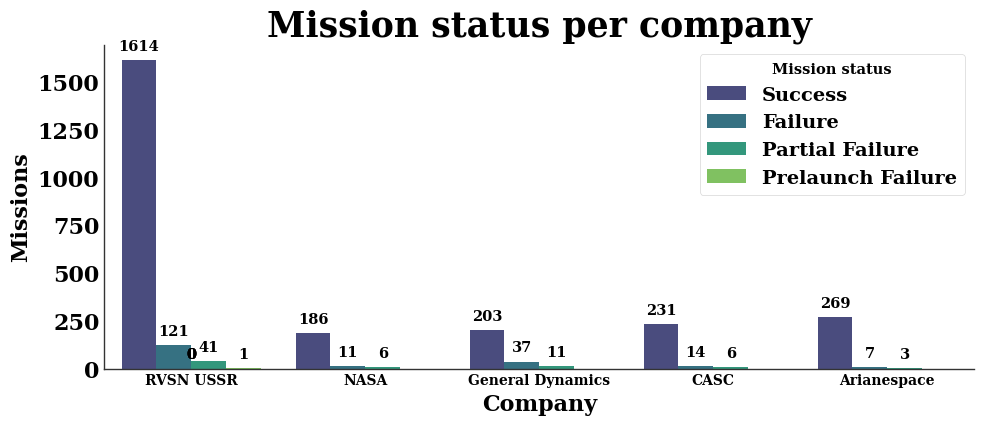

In [39]:
##Misiones por compañía y por estado de la misión

missions_comp_stat = df.loc[:,['company','mission_status']]

top_companies = missions_comp_stat['company'].value_counts(sort=True).head(5).index

missions_comp_stat = missions_comp_stat.loc[missions_comp_stat['company'].isin(top_companies)]

fig, ax = plt.subplots(figsize=(10,4))
axe = sns.countplot(ax=ax,data=missions_comp_stat,x='company',hue='mission_status',palette='viridis')

ax.set_xticks(range(missions_comp_stat['company'].nunique()))
ax.set_xticklabels(missions_comp_stat['company'].unique())
ax.tick_params(axis='x',rotation=0)

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Company')
ax.set_ylabel('Missions')
ax.set_title('Mission status per company')
ax.legend(title='Mission status',fontsize=14)

##Etiquetas a las barras
for p in axe.patches:
    height = p.get_height()
    axe.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                xytext=(0, 5), 
                textcoords='offset points')


plt.show()


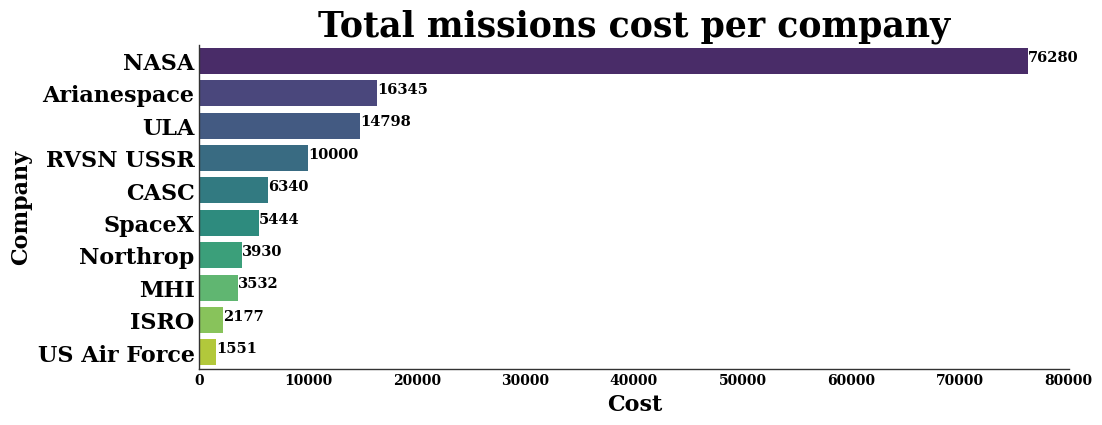

In [40]:
##Análisis de los costos por compañía

cost_company = df.loc[:,['company','cost']].groupby('company')['cost'].sum().reset_index().sort_values(by='cost',ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,4))

ax.spines[['top','right']].set_visible(False)
ax.set_title('Total missions cost per company')
ax.set_xlabel('Cost')
ax.set_ylabel('Company')
sns.barplot(data=cost_company,x='cost',y='company',ax=ax,hue='company',palette='viridis')

for i, valor in enumerate(cost_company['cost']):
    ax.text(valor+0.5,i,str(round(valor)))
plt.show()

### Implementación de Machine Learning - en proceso

In [42]:
## Vamos a determinar qué estado puede tener una misión (Succes, Failure, Partial fealure, prelauch fealure) basado en la compañia que lanza y el año de lanzamiento.

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split


df_cat = df.select_dtypes('O')

encoder = LabelEncoder()

for col in df_cat:
    df[col] = encoder.fit_transform(df[col].astype(str))

x = df[['company','year']]
y = df['mission_status']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=123)

decision_tree = DecisionTreeClassifier(max_depth=5)

decision_tree.fit(x_train,y_train)

y_predict = decision_tree.predict(x_test)

In [43]:
matrix = confusion_matrix(y_test, y_predict)
f1  = f1_score(y_test, y_predict,average='micro')
f1

0.9067796610169492

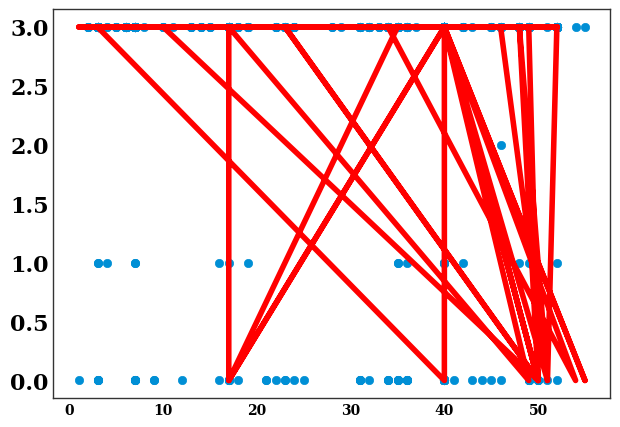

In [44]:
plt.scatter(x_test['company'],y_test)
plt.plot(x_test['company'],y_predict,color='r')